In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import preprocessing

In [88]:
df = pd.read_csv('data.csv', header=0, parse_dates=[0])
df_cleaned = df.dropna().iloc[:,:-1]
df_cleaned.head(5)

,Date,Open,High,Low,Close
0,2021-04-27,14493.80,14667.55,14484.85,14653.05
1,2021-04-28,14710.50,14890.25,14694.95,14864.55
2,2021-04-29,14979.00,15044.35,14814.45,14894.90
3,2021-04-30,14747.35,14855.45,14601.70,14631.10
4,2021-05-03,14481.05,14673.85,14416.25,14634.15


In [89]:
# stock = df_cleaned.copy()
# scaler = preprocessing.MinMaxScaler()
# scaled_values = scaler.fit_transform(stock.iloc[:,1:])
# stock.iloc[:,1:] = scaled_values

# train_X,test_X = train_test_split(stock, test_size=0.33,shuffle=False)

In [90]:
# hmm = GaussianHMM(n_components=4)
# hmm.fit(train_X.iloc[:,1:])

In [91]:
# frac_change_range = np.linspace(0, 1, 10)

# possible_outcomes = np.array(list(itertools.product(frac_change_range, frac_change_range, frac_change_range, frac_change_range)))
# possible_outcomes.shape

In [92]:
# predicted_close_prices = []
# days = 35
# n_latency_days = 10

# pred = []
# actual = []
# for day_index in tqdm(range(n_latency_days, days)):
#     previous_data_start_index = max(0, day_index - n_latency_days)
#     previous_data_end_index = max(0, day_index)
#     previous_data = test_X.iloc[previous_data_start_index: previous_data_end_index,1:]
#     outcome_score = []
#     for possible_outcome in possible_outcomes:
#         total_data = np.row_stack((previous_data, possible_outcome))
#         outcome_score.append(hmm.score(total_data))
#     print(total_data)

#     most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]
#     pred.append([test_X.iloc[day_index,0]].append(scaler.inverse_transform(most_probable_outcome.reshape(1,-1))))
#     actual.append([test_X.iloc[day_index,:]])

In [93]:
class StockPredictor(object):
    def __init__(self, test_size=0.33,
                 n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=50, n_steps_frac_high=10,
                 n_steps_frac_low=10):
 
        self.n_latency_days = n_latency_days
 
        self.hmm = GaussianHMM(n_components=n_hidden_states)
 
        self._split_train_test_data(test_size)
 
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    def _split_train_test_data(self, test_size):
        data = df_cleaned
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
        self._test_data.reset_index(inplace = True)
        self._test_data = self._test_data.drop(columns=['index'])

    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])
 
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((frac_change, frac_high, frac_low))
 
    def fit(self):
        feature_vector = StockPredictor._extract_features(self._train_data)
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
 
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index)
        previous_data = self._test_data.iloc[previous_data_start_index: previous_data_end_index,:]
        previous_data_features = StockPredictor._extract_features(
            previous_data)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))

        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]

        return most_probable_outcome

    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(
            day_index)
        return open_price * (1 + predicted_frac_change)
 
    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
 
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data['Date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['Close']
 
            fig = plt.figure()
 
            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
 
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show()

100%|██████████| 75/75 [01:44<00:00,  1.39s/it]


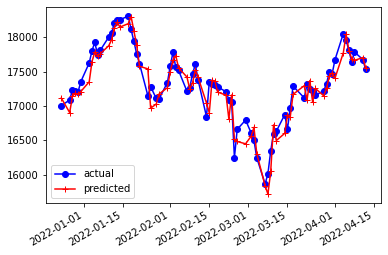

In [94]:
stock_predictor = StockPredictor()
stock_predictor.fit()
stock_predictor.predict_close_prices_for_days(75, with_plot=True)